# Sorted spike shapes

author: steeve.laquitaine@epfl.ch  
date: 06.02.2024  
purpose: Explore sorted spike shapes

tested on: 
- Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K @3.2 GHz/5.8 GHz)

Observations:

* Pauk et al., plotted spike periods of 0.55 ms (Human data) - 0.667 ms for 146.75 points width -> 110 points for 0.5 ms
* Sun et al., plotted spike periods of 2.5 ms (Cat data)
* Our spikes durations are longer than the cat's and much longer than Humans, up to 6 ms. On our figure: 106.5 points width for 6 ms duration -> 0.5 ms legend bar = 8.875 points width

## Pre-requisites

Spike sorting (21 min): `notebooks/0_method/4_sorting/silico/0_marques/sorting.ipynb`

## Setup 

Activate spikebias conda environment

In [34]:
%%time
%load_ext autoreload
%autoreload 2

# import libs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
from concurrent.futures import ProcessPoolExecutor
from ipywidgets import interactive, widgets
import spikeinterface.core.template_tools as ttools
import spikeinterface as si
from spikeinterface import extract_waveforms
import spikeinterface.preprocessing as spre

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.postpro import waveform
from src.nodes.prepro.run import run as prep

# SETUP PARAMETERS
MS_BEFORE = 6           # ms
MS_AFTER = 6            # ms
SFREQ = 40000

# biophy npx spont 
RAW_PATH = os.path.join(PROJ_PATH, "dataset/00_raw/recording_npx_spont")
PREP_PATH = os.path.join(PROJ_PATH, "dataset/01_intermediate/preprocessing/recording_npx_spont")
WAVE_PATH = os.path.join(PROJ_PATH, "dataset/01_intermediate/waveforms/npx_spont/SortingKS3") 
#SORT_PATH = os.path.join(PROJ_PATH, "dataset/01_intermediate/sorting/npx_spont/SortingKS3_10m")
SORT_PATH = os.path.join(PROJ_PATH, "dataset/01_intermediate/sorting/npx_spont/SortingKS3")

# biophy npx evoked
RAW_PATH_E = os.path.join(PROJ_PATH, "dataset/00_raw/recording_npx_spont")
PREP_PATH_E = os.path.join(PROJ_PATH, "dataset/01_intermediate/preprocessing/recording_npx_spont")
WAVE_PATH_E = os.path.join(PROJ_PATH, "dataset/01_intermediate/waveforms/npx_spont/SortingKS3") 
#SORT_PATH = os.path.join(PROJ_PATH, "dataset/01_intermediate/sorting/npx_spont/SortingKS3_10m")
SORT_PATH_E = os.path.join(PROJ_PATH, "dataset/01_intermediate/sorting/npx_spont/SortingKS3")

# set parameters
REC_SECS = 1800             # duration of recording (longer produces kernel)
FREQ_MIN = 300              # lower cutoff of bandpass filtering
FREQ_MAX = 10000            # 10000 (Paulk, NNeuro, 2022); 6000 Hz (Buccino); 14,250 Hz (Sun JNp, 2022)
SAVE_REC = False            # save preprocessed recording
LOAD_WE_IF_EXISTS = False   # load waveforms if already extracted
PAULK_PERIOD = 0.55
SUN_PERIOD = 4
OUR_PERIOD = 6
N_JOBS = 20                 # (default = 20) number of parallel processes for waveform extraction (20/32)
CHUNKS = 50000             # (default = 800000) use smaller chunks to use less RAM
MAX_SPIKES_PER_UNIT = 500   # (default = 500) max number of spikes used per unit
SAVE_FIG = True
JOB_KWARGS = dict(n_jobs=N_JOBS, chunk_size=800000, progress_bar=True)

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 843 µs, sys: 0 ns, total: 843 µs
Wall time: 729 µs


## Extract waveforms

The speed/RAM usage tradeoff depends on N_JOBS, CHUNKS, int16 compression, REC_SECS  
Troubleshooting: comment out the plots of all single-unit waveforms below to save RAM, else can crash.


In [35]:
%%time

# load recording
Recording = si.load_extractor(RAW_PATH)
Recording = spre.astype(Recording, "int16")

# sample first 10 min of recording
Recording = Recording.frame_slice(start_frame=0, end_frame=SFREQ*REC_SECS)

# preprocess recording
Recording = prep(Recording, freq_min=FREQ_MIN, freq_max=FREQ_MAX)

# save recording
if SAVE_REC:
    Recording.save(folder=PREP_PATH, n_jobs=N_JOBS, 
                verbose=True, progress_bar=True, overwrite=True, 
                dtype="float32", chunk_size=CHUNKS)

# load sorting
Sorting = si.load_extractor(SORT_PATH)
Sorting = Sorting.frame_slice(start_frame=0, end_frame=SFREQ*REC_SECS)

# extract waveforms (5 GB)
# warning: crashes for sparse=False and more than 10 min recording
We = extract_waveforms(Recording, Sorting, WAVE_PATH, 
                       sparse=True, ms_before=MS_BEFORE,
                       ms_after=MS_AFTER, max_spikes_per_unit=500,
                       unit_batch_size=CHUNKS, overwrite=True if LOAD_WE_IF_EXISTS==False else False,
                       seed=0, load_if_exists=LOAD_WE_IF_EXISTS, **JOB_KWARGS)

# get single units
single_units = Sorting.get_property("KSLabel") == "good"
single_units = We.unit_ids[single_units]
print("number of single-units:", len(single_units))
print("single units:", single_units)

2025-06-21 21:45:23,896 - root - run.py - run - INFO - Band-pass filtered in 0.0 secs
2025-06-21 21:45:23,897 - root - run.py - run - INFO - Pipeline completed in 0.0 secs


/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(
/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


extract waveforms shared_memory multi buffer:   0%|          | 0/90 [00:00<?, ?it/s]

/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


extract waveforms memmap multi buffer:   0%|          | 0/90 [00:00<?, ?it/s]

number of single-units: 335
single units: [ 143  201  208  215  217  221  225  227  228  232  233  235  236  244
  248  250  253  254  255  259  264  270  272  273  274  275  276  280
  285  286  288  289  290  300  302  307  309  318  321  322  325  326
  328  331  334  335  338  339  340  345  347  355  356  364  365  369
  371  378  379  380  382  384  397  399  409  411  414  418  421  426
  428  430  443  444  447  456  466  468  470  473  474  477  478  482
  488  490  497  506  510  515  517  518  519  527  532  533  540  541
  542  551  553  554  564  575  577  579  581  594  597  601  606  608
  616  620  624  639  644  650  661  673  677  684  692  694  732  735
  743  746  753  756  759  760  761  764  766  769  771  773  777  780
  781  787  788  796  797  800  810  811  818  819  821  822  824  825
  826  827  831  840  850  854  860  863  867  873  875  878  879  885
  886  890  892  898  900  903  909  910  913  922  925  926  932  936
  947  952  955  956  957  959  962

## Plot  single-site mean waveform

### mean vs median

In [39]:
def get_unit_largest_median_templates_parallelized(array, cell_id):
    N_SPIKES = 1

    # get waveforms
    wfs = We.get_waveforms(cell_id)
    n_sites =  wfs.shape[2]

    # get this unit's templates per site
    site_templates = []
    peak_to_peak_amps = []
    for site in range(n_sites):
        template = np.median(wfs[:, :, site].T, axis=1)
        peak_to_peak_amps.append(max(template) - min(template))
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get six largest average spikes (templates) and concatenate as a single row instance for UMAP
    descend_sort_ix = np.argsort(peak_to_peak_amps)[::-1]
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]].T.flatten()
    return unit_i_spike

def get_unit_largest_mean_templates_parallelized(array, cell_id):
    N_SPIKES = 1

    # get waveforms
    wfs = We.get_waveforms(cell_id)
    n_sites =  wfs.shape[2]

    # get this unit's templates per site
    site_templates = []
    peak_to_peak_amps = []
    for site in range(n_sites):
        template = np.mean(wfs[:, :, site].T, axis=1)
        peak_to_peak_amps.append(max(template) - min(template))
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get six largest average spikes (templates) and concatenate as a single row instance for UMAP
    descend_sort_ix = np.argsort(peak_to_peak_amps)[::-1]
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]].T.flatten()
    return unit_i_spike

def update_plot(unit):
    """plot unit spike template

    Args:
        unit (_type_): _description_
    """
    # select unit to display
    unit_ids = single_units[unit]
    print("unit id:", unit_ids)

    # compute unit's max template
    with ProcessPoolExecutor() as executor:
        site_median_templates = executor.map(
            get_unit_largest_median_templates_parallelized,
            np.arange(0, 1, 1),  # dummy not used
            [unit_ids],
        )
    site_median_templates = list(site_median_templates)

    # format for wavemap
    median_templates_for_wavemap = np.array(site_median_templates[0].tolist())

    # compute unit's max mean template
    with ProcessPoolExecutor() as executor:
        site_mean_templates = executor.map(
            get_unit_largest_mean_templates_parallelized,
            np.arange(0, 1, 1),  # dummy not used
            [unit_ids],
        )
    site_mean_templates = list(site_mean_templates)

    # format for wavemap
    mean_templates_for_wavemap = np.array(site_mean_templates[0].tolist())

    # plot
    f, axis = plt.subplots(nrows=1, figsize=(4, 4))
    axis.plot(median_templates_for_wavemap)
    axis.plot(mean_templates_for_wavemap, "r")
    axis.set_xticks([0, len(mean_templates_for_wavemap)/2, len(mean_templates_for_wavemap)],[-MS_BEFORE,0, MS_AFTER])
    axis.set_xlabel("Time (ms)")
    plt.show()

def get_max_site_id(We, cell_id):
    """get index of max site id, among the sparse subset of 
    sites used for the waveform"""
    max_chids = ttools.get_template_extremum_channel(
        We, peak_sign="both"
    )
    c_ids = We.sparsity.unit_id_to_channel_ids[cell_id]
    max_chid = max_chids[cell_id]
    return np.where(c_ids == max_chid)[0][0]

def get_samples_for_duration(duration_ms, We):
    n_sp_before = duration_ms/1000/2 * We.sampling_frequency 
    n_sp_after = n_sp_before
    center_sp = We.nsamples/2
    sp_start = int(center_sp - n_sp_before)
    sp_end = int(center_sp + n_sp_after)
    return np.arange(sp_start, sp_end, 1)

def plot_centered_waveform(
    We,
    cell_id,
    nspike=100,
    centered_len=100,
    time_axis=None,
    ax=None,
    color_waveforms=(199/255, 179/255, 68/255, 100/255),
    color_template=(168/255, 151/255, 55/255, 100/255),
    max_chids=None
):
    """
    Plots spike waveforms and the average template waveform centered on the negative peak.

    Parameters:
        We : waveform extractor object
        cell_id : int
            Cell ID to extract waveforms for.
        nspike : int
            Number of individual spikes to plot.
        centered_len : int
            Number of samples to center around the peak.
        time_axis : array-like or None
            Time axis to use. If None, a default axis is generated.
        ax : matplotlib axis or None
            If None, a new figure and axis will be created.
        color_waveforms : RGBA tuple
            Color of individual spike waveforms.
        color_template : RGBA tuple
            Color of the average waveform.
        max_chids : dict or None
            Optional precomputed dict of cell_id to max channel ID.
    """
    half_len = centered_len // 2

    if max_chids is None:
        max_chids = ttools.get_template_extremum_channel(We, peak_sign="both")

    max_site_ix = get_max_site_id(We, cell_id)

    # Get full template and locate negative peak
    full_tmp = We.get_template(cell_id)
    peak_ix = np.argmin(full_tmp[:, max_site_ix])

    # Safe bounds for indexing
    start_ix = max(0, peak_ix - half_len)
    end_ix = start_ix + centered_len
    if end_ix > full_tmp.shape[0]:
        end_ix = full_tmp.shape[0]
        start_ix = end_ix - centered_len
    extract_ix = np.arange(start_ix, end_ix)

    # Get centered waveforms
    waveform = We.get_waveforms(cell_id)[:, extract_ix, :]
    each_wvf = waveform[:nspike, :, max_site_ix].T

    # Get centered mean template
    tmp = full_tmp[extract_ix, :]

    # Create axis if needed
    if ax is None:
        fig = plt.figure(figsize=(3, 3))
        ax = fig.add_subplot(1, 1, 1)

    # Generate time axis if not provided
    if time_axis is None:
        time_axis = np.linspace(-centered_len / 2, centered_len / 2, num=centered_len)

    # Plot waveforms
    for k in range(each_wvf.shape[1]):
        ax.plot(time_axis, each_wvf[:, k], color=color_waveforms, lw=1, alpha=0.5, zorder=1)

    # Plot average
    ax.plot(time_axis, tmp[:, max_site_ix], color=color_template, lw=3, zorder=np.inf, alpha=1.0)

    # Labels
    ax.set_title(f"Cell {cell_id}, Ch {int(max_chids[cell_id])}", fontsize=9)
    ax.set_xlabel("Time (ms)", fontsize=8)
    ax.set_ylabel("Potential (uV)", fontsize=8)
    ax.tick_params(labelsize=7)

    if ax is None:
        plt.tight_layout()
        plt.show()

In [ ]:
# get slider's value interactively
slider = widgets.IntSlider(value=0, min=0, max=len(single_units) - 1, step=1,
    disabled=False, continuous_update=False, orientation="horizontal",
    readout=True, readout_format="d")

# plot interactively
interactive(update_plot, unit=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='unit', max=334), Output()), _do…

### All KS3-labelled single-units

Warning: uses RAM

Note: As we will see in subsequent analyeses, some sorted unit waveforms are biased (overmerging and/or oversplitting) and require curation. This can explain some of the distorted shapes observed.

TODO: re-center the spikes on their negative peaks.

- take longer duration (12 ms), find location of negative peak, plot its surrounding -1.25 to 1.25 ms.


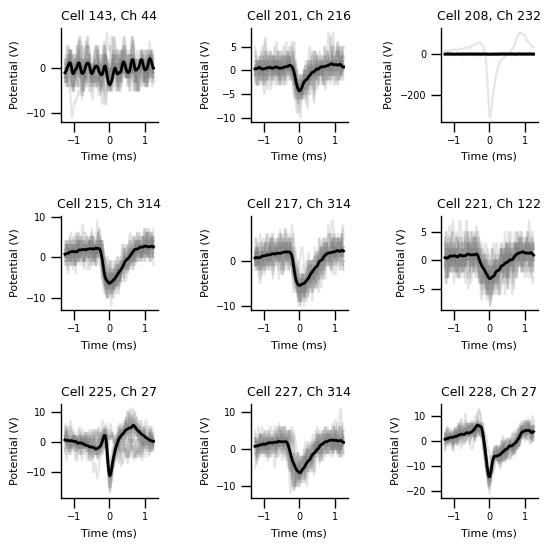

number of samples: 100


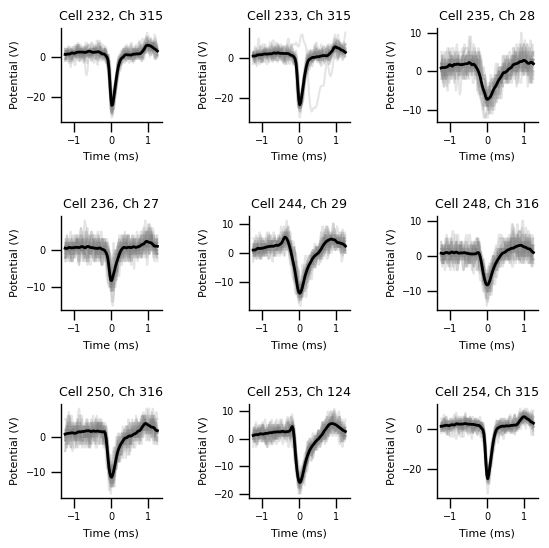

number of samples: 100


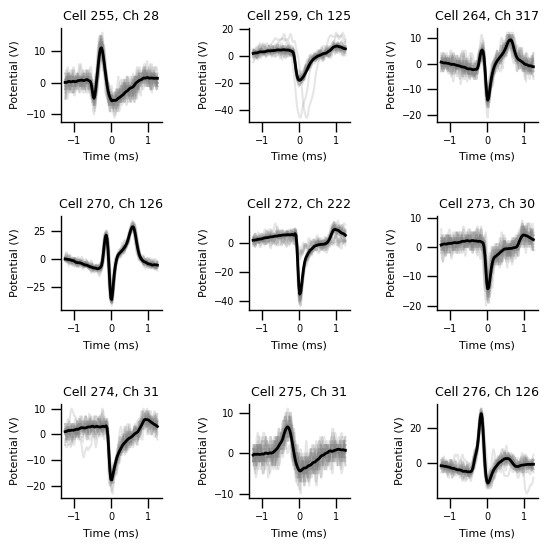

number of samples: 100


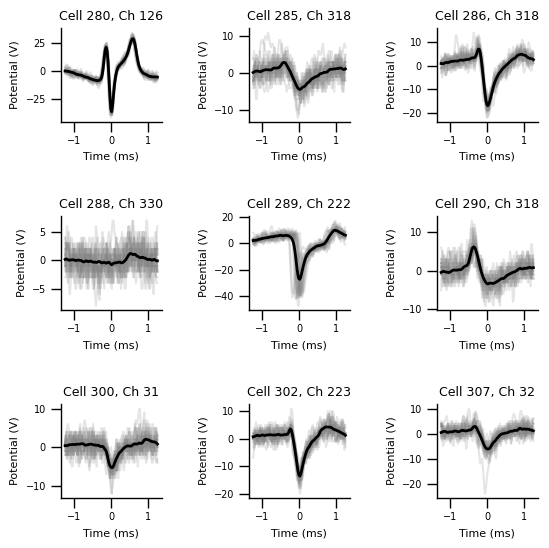

number of samples: 100


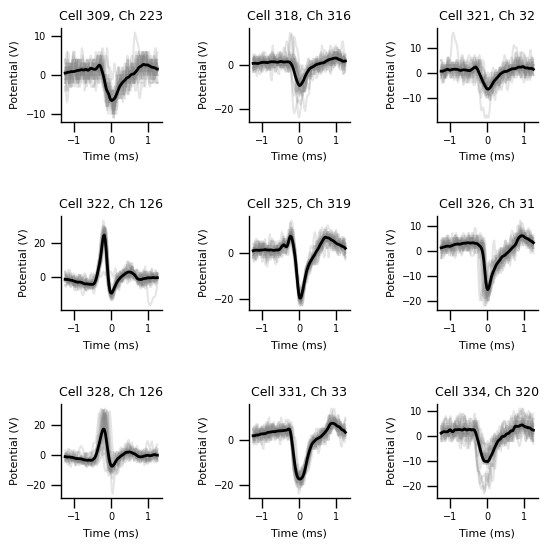

number of samples: 100


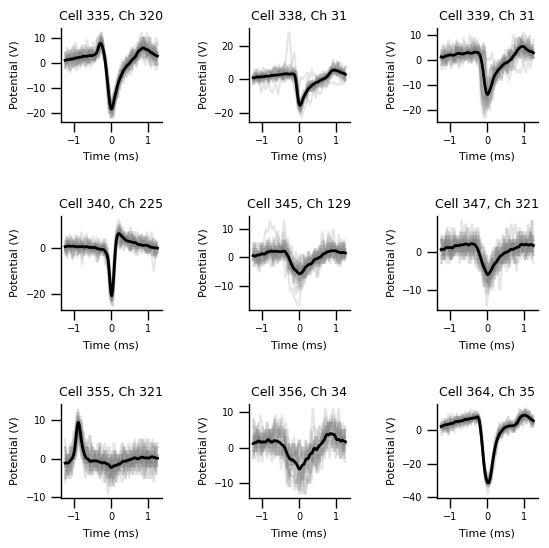

number of samples: 100


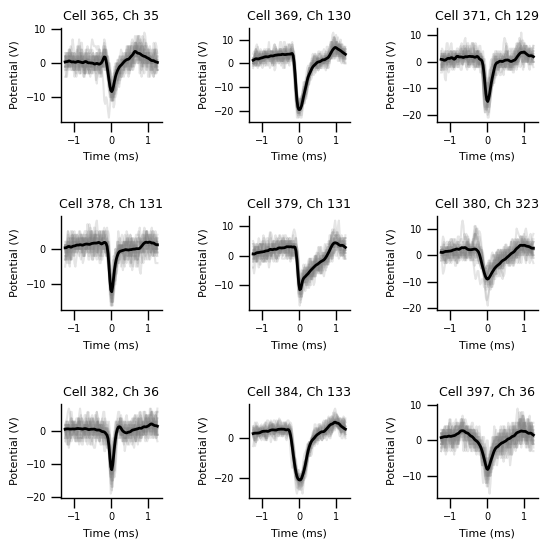

number of samples: 100


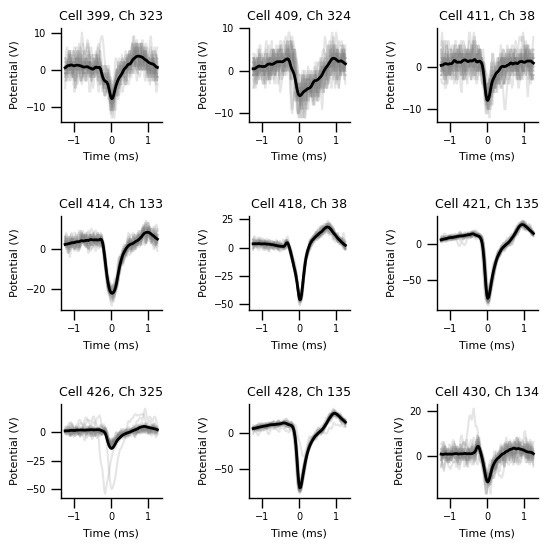

number of samples: 100


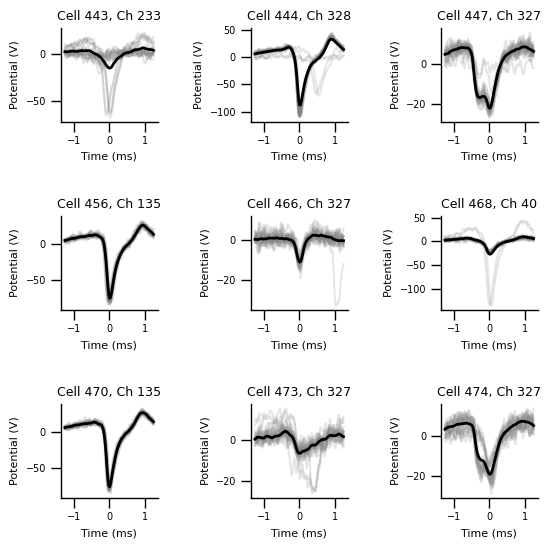

number of samples: 100


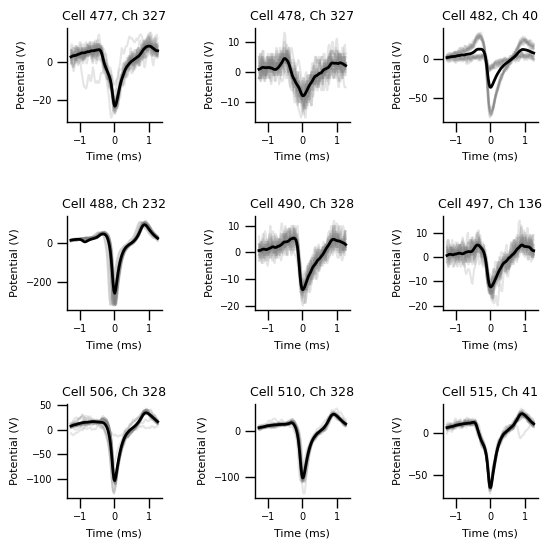

number of samples: 100


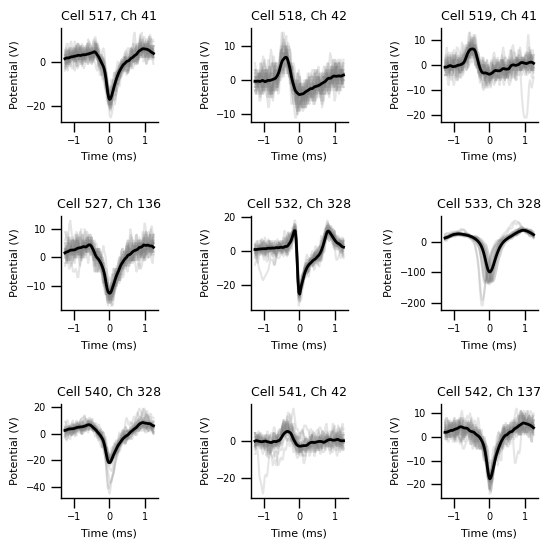

number of samples: 100


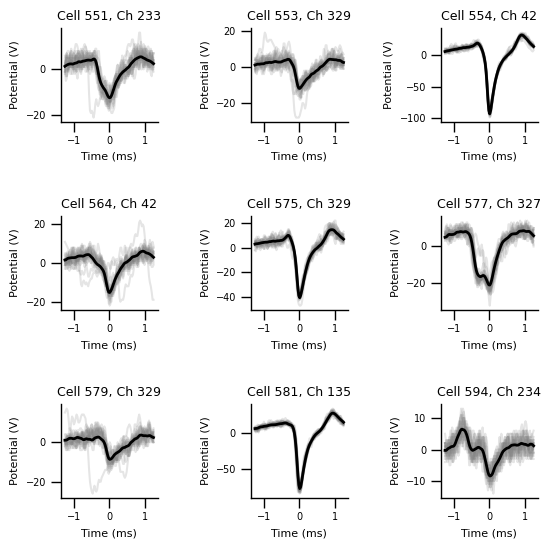

number of samples: 100


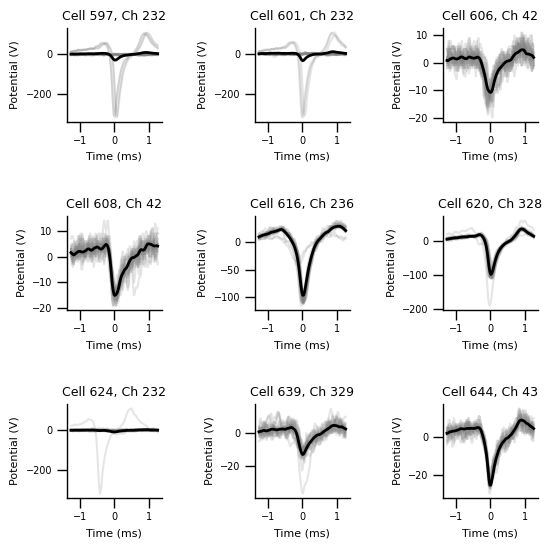

number of samples: 100


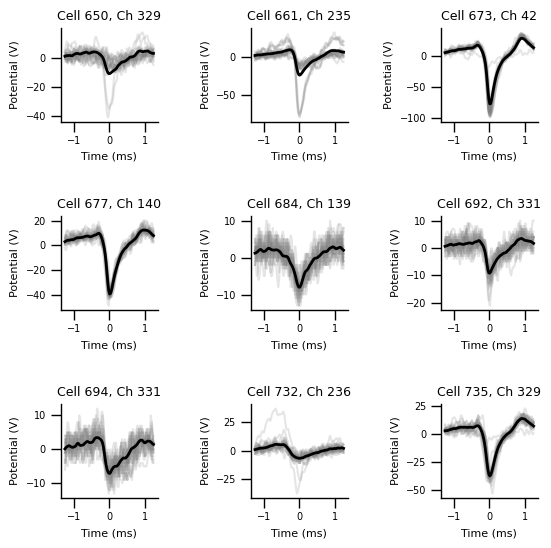

number of samples: 100


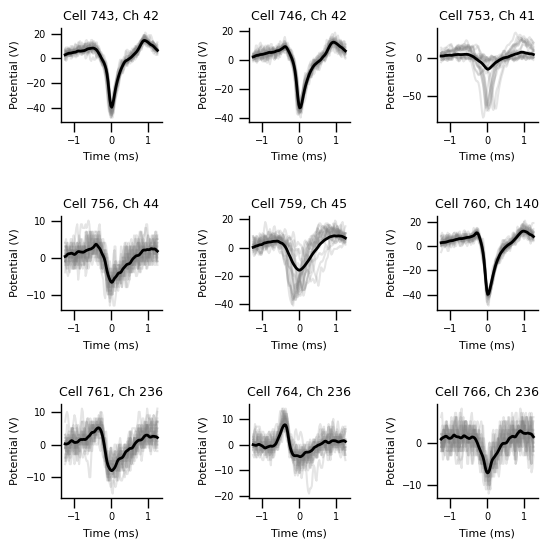

number of samples: 100


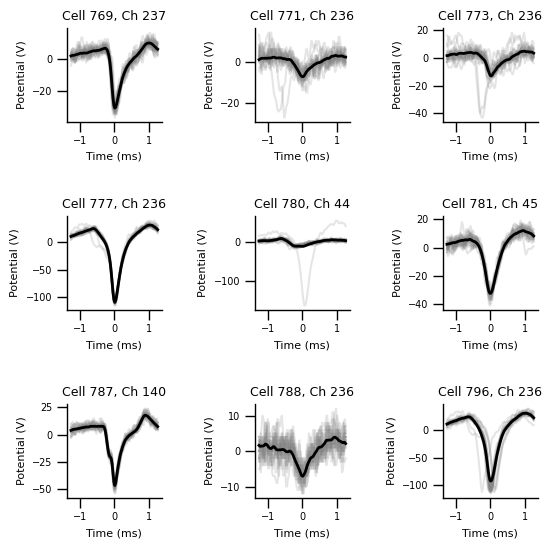

number of samples: 100


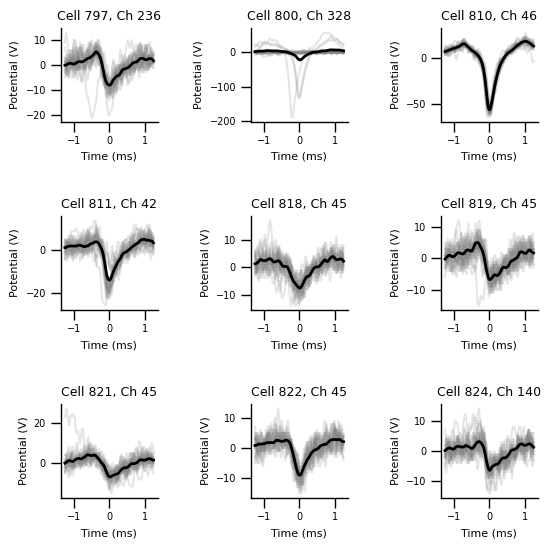

number of samples: 100


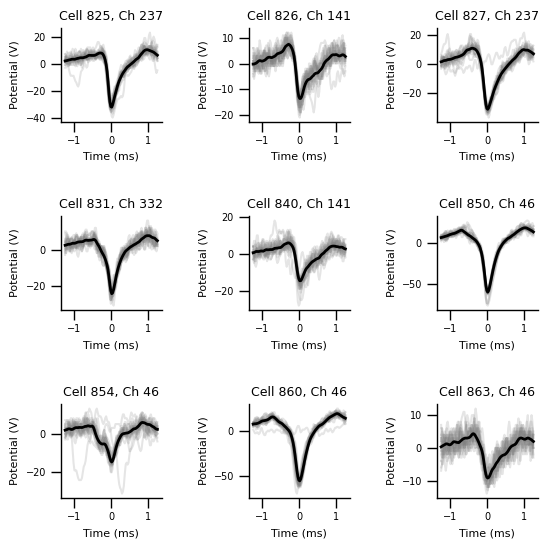

number of samples: 100


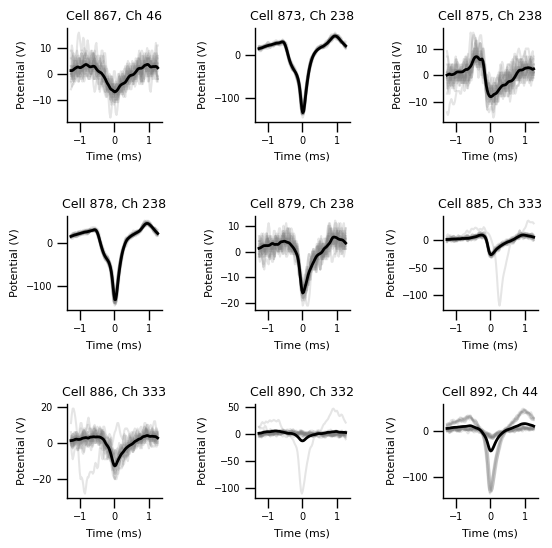

number of samples: 100


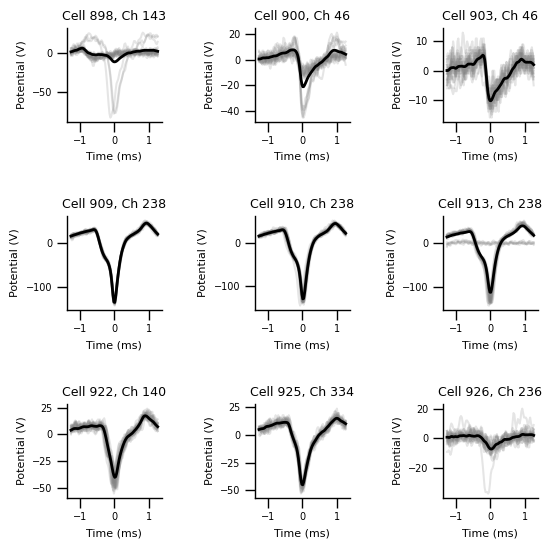

number of samples: 100


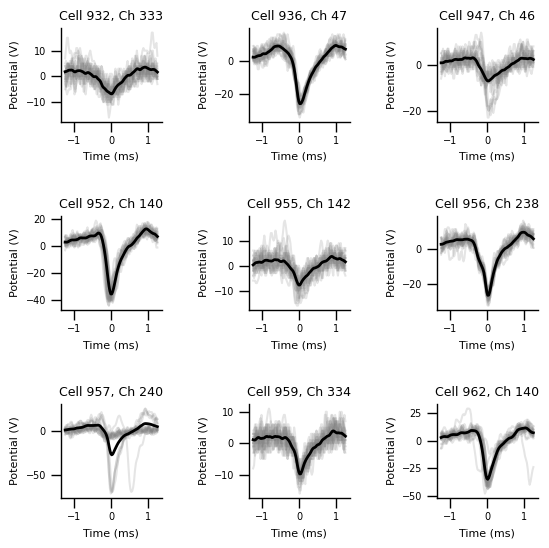

number of samples: 100


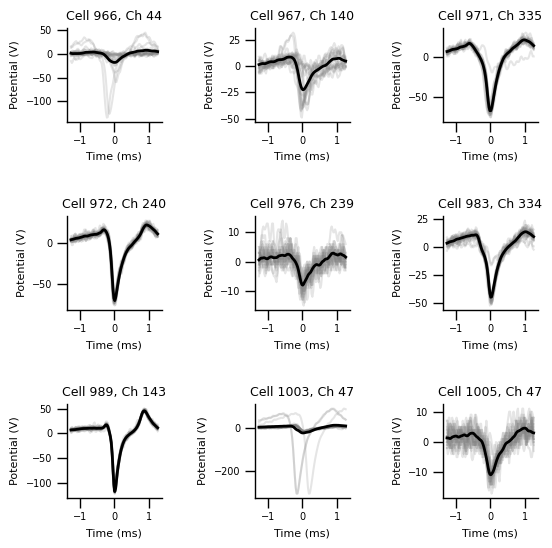

number of samples: 100


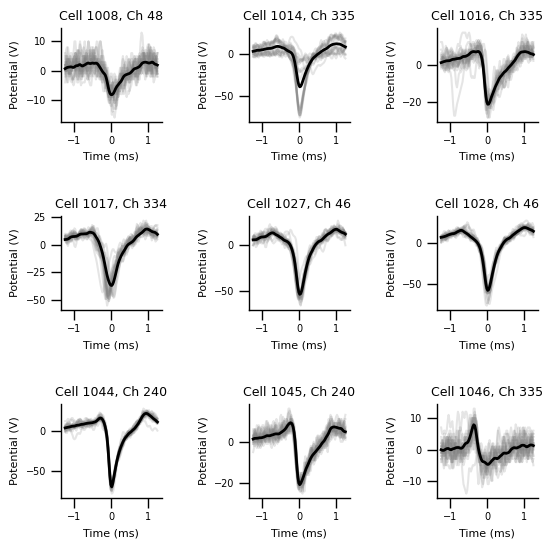

number of samples: 100


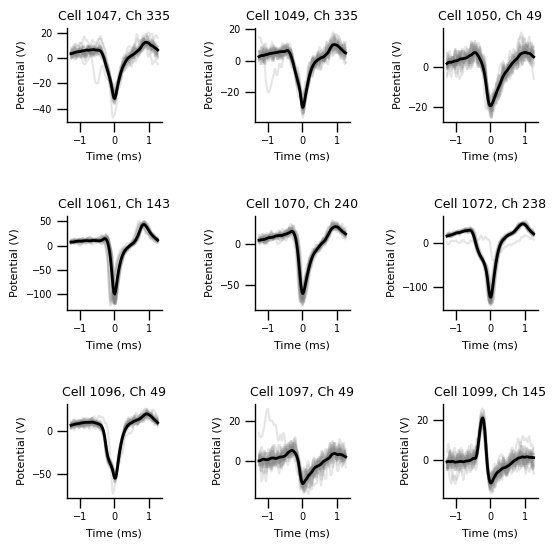

number of samples: 100


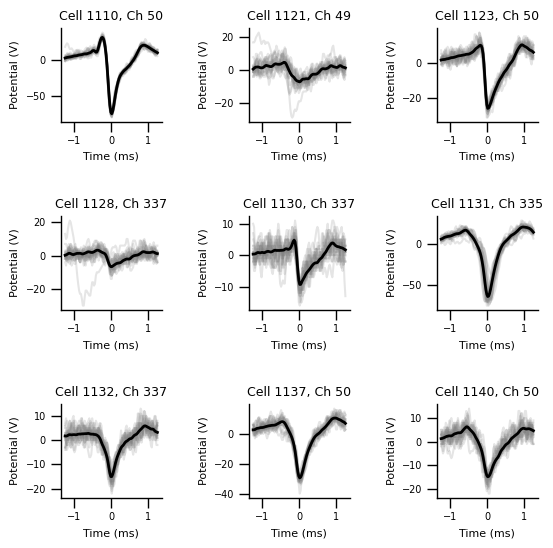

number of samples: 100


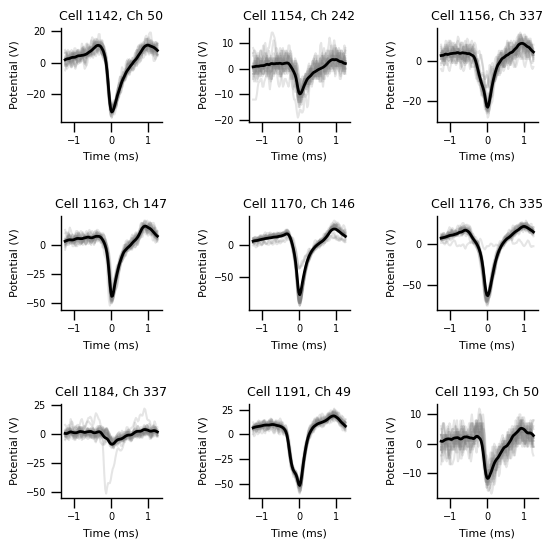

number of samples: 100


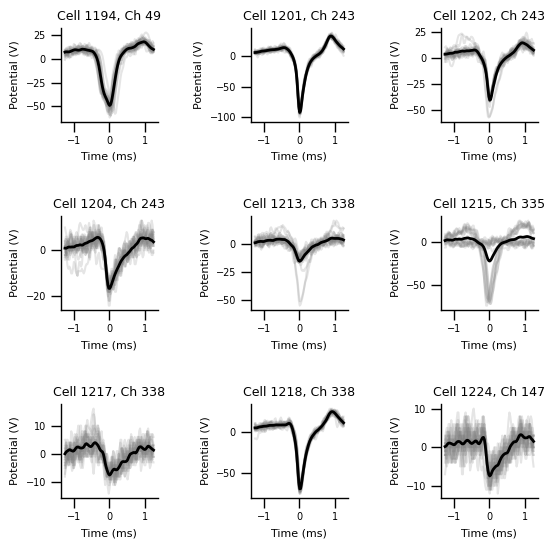

number of samples: 100


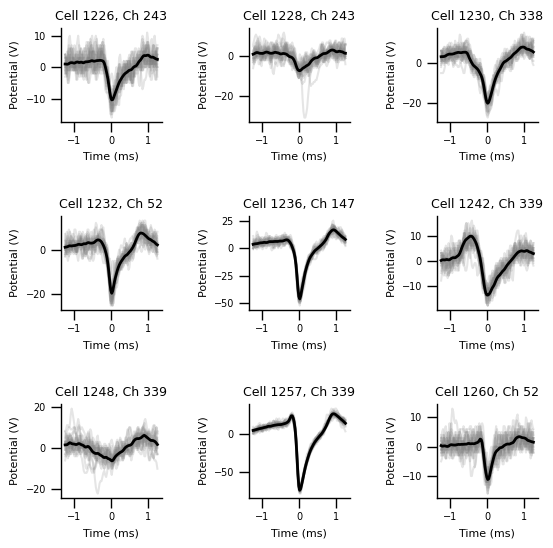

number of samples: 100


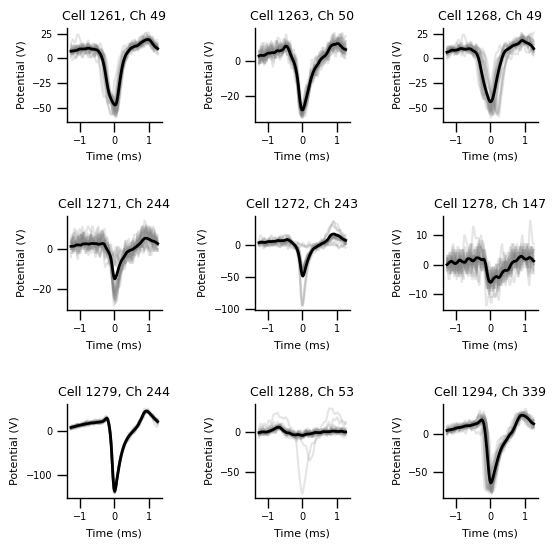

number of samples: 100


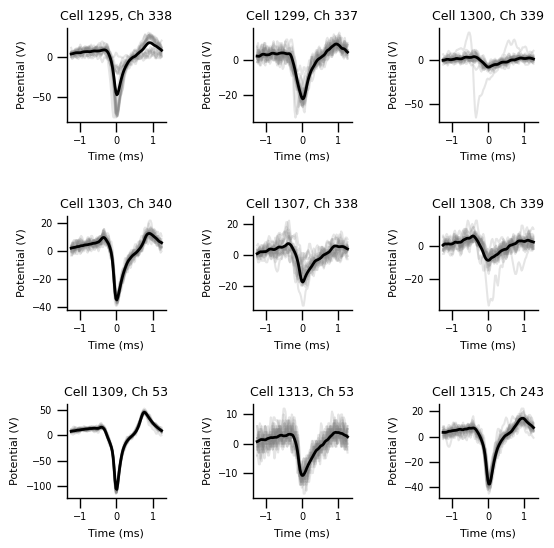

number of samples: 100


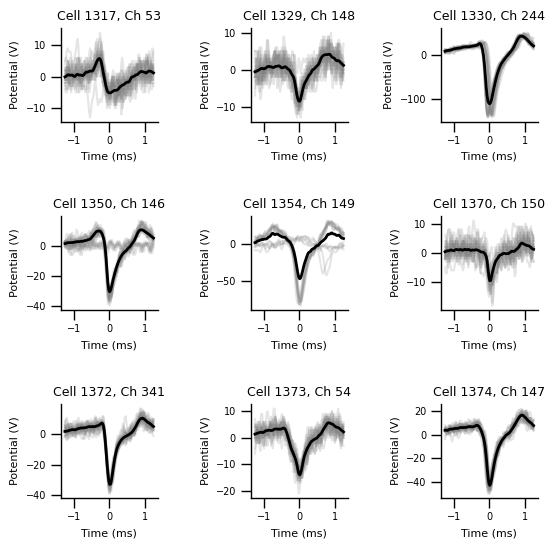

number of samples: 100


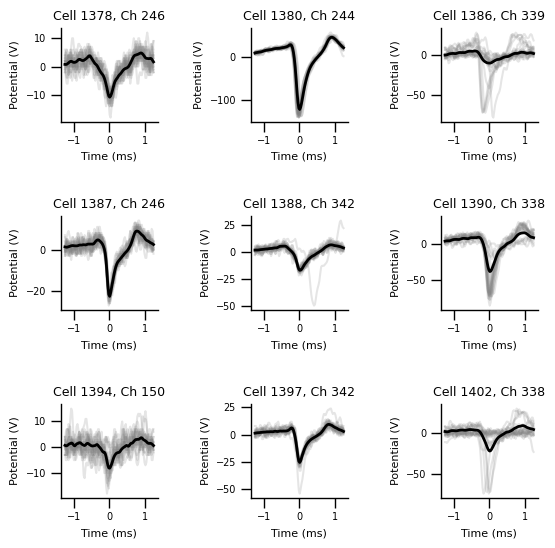

number of samples: 100


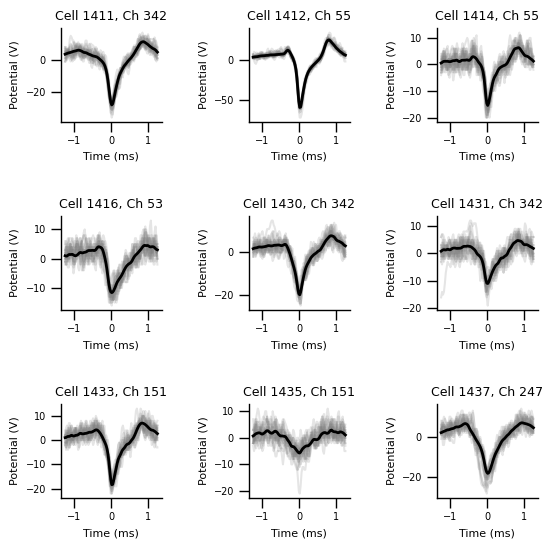

number of samples: 100


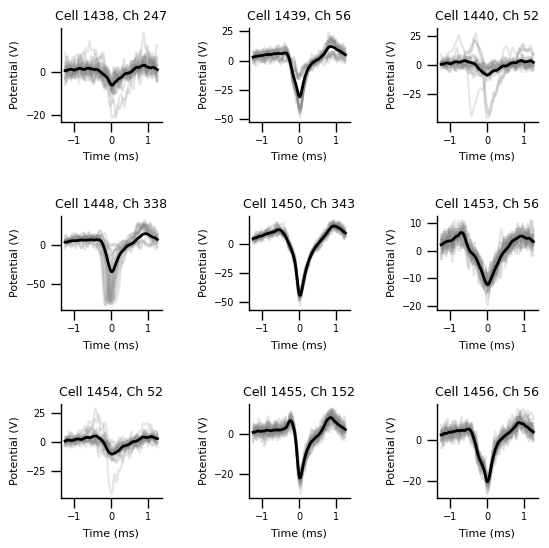

number of samples: 100


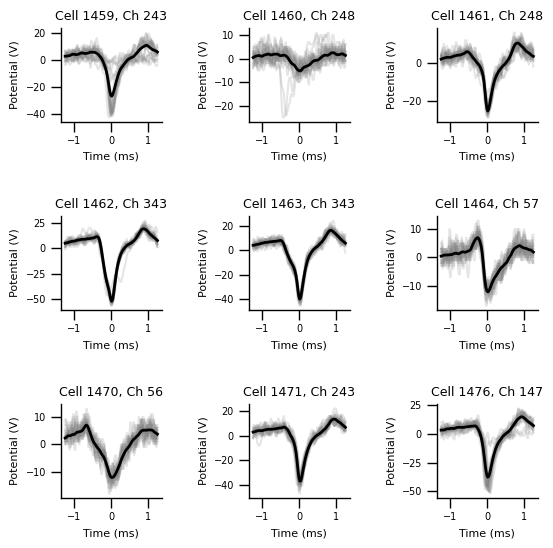

number of samples: 100


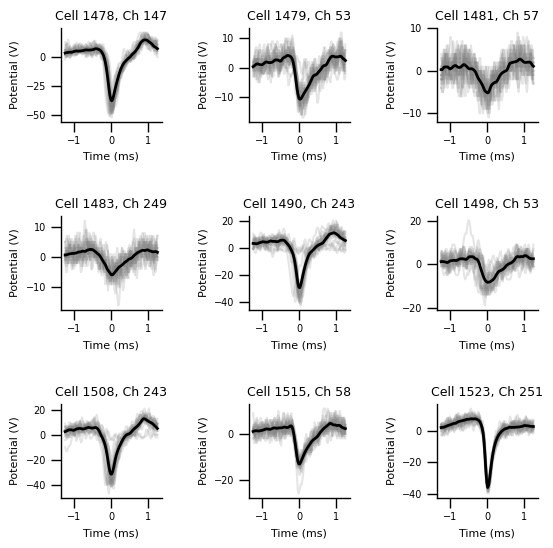

number of samples: 100


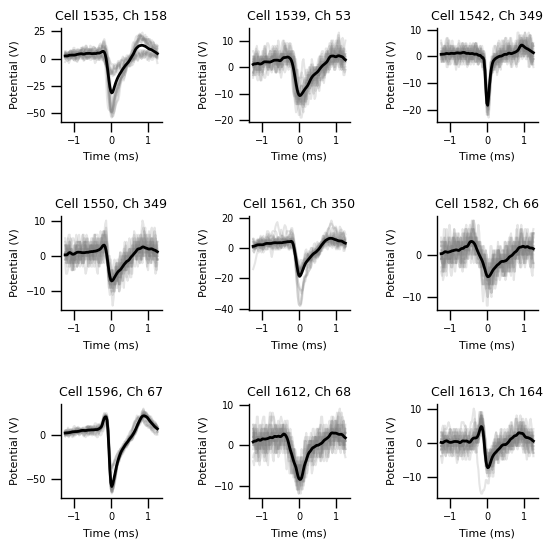

number of samples: 100


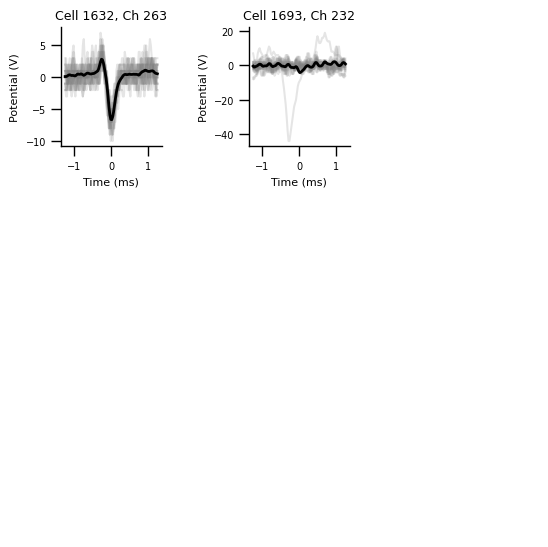

number of samples: 100


In [43]:
# Plotting parameters
colors = [(0.5, 0.5, 0.5), (0, 0, 0)]
linewdth = 1.5
linewidth_mean = 2
NSPIKE = 20
centered_len = 100  # centered sample window length
half_len = centered_len // 2
duration_ms = 2.5  # used only for time axis
sample_ix = get_samples_for_duration(duration_ms, We)

# Peri-spike time axis
ms_before = -duration_ms / 2
ms_after = duration_ms / 2
time_axis = np.linspace(ms_before, ms_after, num=centered_len)

# Get max channel per cell
#max_chids = ttools.get_template_extremum_channel(We, peak_sign="both")
max_chids = ttools.get_template_extremum_channel(We, peak_sign="neg")

# Define batching
cell_ids = single_units  # or use a specific list
cells_per_fig = 9  # 3x3 grid
n_batches = int(np.ceil(len(cell_ids) / cells_per_fig))

for batch_idx in range(n_batches):
    fig, axs = plt.subplots(3, 3, figsize=(6,6))
    axs = axs.flatten()

    for i in range(cells_per_fig):
        cell_idx = batch_idx * cells_per_fig + i
        if cell_idx >= len(cell_ids):
            axs[i].axis('off')
            continue

        cell_id = cell_ids[cell_idx]
        max_site_ix = get_max_site_id(We, cell_id)

        # Full waveform to locate negative peak
        full_tmp = We.get_template(cell_id)  # shape: [time, channels]
        peak_ix = np.argmin(full_tmp[:, max_site_ix])

        # Handle boundary clipping
        start_ix = max(0, peak_ix - half_len)
        end_ix = start_ix + centered_len
        if end_ix > full_tmp.shape[0]:
            end_ix = full_tmp.shape[0]
            start_ix = end_ix - centered_len
        extract_ix = np.arange(start_ix, end_ix)

        # Get centered waveforms
        waveform = We.get_waveforms(cell_id)[:, extract_ix, :]  # shape: [spikes, time, chans]
        each_wvf = waveform[:NSPIKE, :, max_site_ix].T  # shape: [time, spikes]

        # Get centered mean template
        tmp = full_tmp[extract_ix, :]

        # Plot
        axs[i].plot(time_axis, each_wvf, color=colors[0], lw=linewdth, alpha=0.2)
        axs[i].plot(time_axis, tmp[:, max_site_ix], color=colors[1], lw=linewidth_mean)

        axs[i].set_title(f"Cell {cell_id}, Ch {int(max_chids[cell_id])}", fontsize=9)
        axs[i].set_xlabel("Time (ms)", fontsize=8)
        axs[i].set_ylabel("Potential (V)", fontsize=8)
        axs[i].tick_params(labelsize=7)

    plt.tight_layout()
    plt.show()
    print("number of samples:", len(sample_ix))


## Five waveforms type

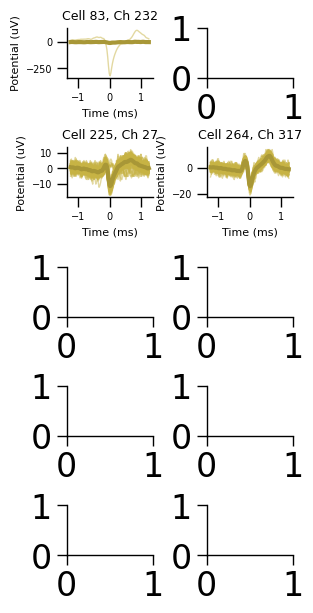

In [ ]:
# setup plots
fig, ax = plt.subplots(5,2, figsize=(3,6))
time_axis = np.linspace(ms_before, ms_after, num=centered_len)

# positive waveforms
plot_centered_waveform(We, cell_id=83, nspike=100, centered_len=100, time_axis=time_axis, ax=ax[0,0],
    color_waveforms=(199/255, 179/255, 68/255, 100/255),
    color_template=(168/255, 151/255, 55/255, 100/255),
    max_chids=max_chids
)

# tri-phasic waveforms
plot_centered_waveform(We, cell_id=225, nspike=100, centered_len=100, time_axis=time_axis, ax=ax[1,0],
    color_waveforms=(199/255, 179/255, 68/255, 100/255),
    color_template=(168/255, 151/255, 55/255, 100/255),
    max_chids=max_chids
)
plot_centered_waveform(We, cell_id=264, nspike=100, centered_len=100, time_axis=time_axis, ax=ax[1,1],
    color_waveforms=(199/255, 179/255, 68/255, 100/255),
    color_template=(168/255, 151/255, 55/255, 100/255),
    max_chids=max_chids
)

plt.tight_layout(pad=0.1)

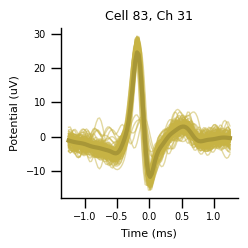

In [128]:
CELL_ID =  83
NSPIKE = 100

# get nearest (max peak) channel
max_site_ix = get_max_site_id(We, CELL_ID)

# Full waveform to locate negative peak
full_tmp = We.get_template(CELL_ID)  # shape: [time, channels]
peak_ix = np.argmin(full_tmp[:, max_site_ix])

# Handle boundary clipping
start_ix = max(0, peak_ix - half_len)
end_ix = start_ix + centered_len
if end_ix > full_tmp.shape[0]:
    end_ix = full_tmp.shape[0]
    start_ix = end_ix - centered_len
extract_ix = np.arange(start_ix, end_ix)

# get centered waveforms
waveform = We.get_waveforms(CELL_ID)[:, extract_ix, :]  # shape: [spikes, time, chans]
each_wvf = waveform[:NSPIKE, :, max_site_ix].T  # shape: [time, spikes]

# get centered mean template
tmp = full_tmp[extract_ix, :]

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)

# Plot
ax.plot(time_axis, each_wvf, color=[199/255, 179/255, 68/255, 100/255], lw=1, alpha=0.5) # each waveform
ax.plot(time_axis, tmp[:, max_site_ix], color=[168/255, 151/255, 55/255, 100/255], lw=3, zorder=np.inf, alpha=1.0) # average

ax.set_title(f"Cell {CELL_ID}, Ch {int(max_chids[CELL_ID])}", fontsize=9)
ax.set_xlabel("Time (ms)", fontsize=8)
ax.set_ylabel("Potential (uV)", fontsize=8)
ax.tick_params(labelsize=7)

plt.tight_layout()

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/5_spikes/fig3_c_positive.svg", **savefig_cfg)
    fig

ValueError: [189, 170, 63, 100] is not a valid value for color

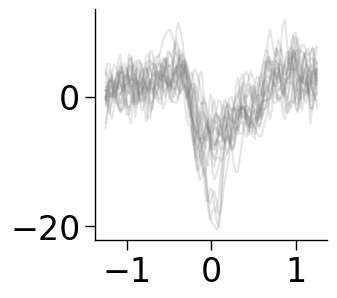

In [139]:
cell_id = 142 #142 # 68 (-20)
colors = [(0.5, 0.5, 0.5), (0, 0, 0)]  # orange
linewdth = 1.5
linewidth_mean = 2
nspike = 20
duration_ms = 2.5

# get channels where spike amplitude is maximal
max_chids = ttools.get_template_extremum_channel(
    We, peak_sign="both"
)

# get cell waveforms
waveform = We.get_waveforms(cell_id)
sample_ix = get_samples_for_duration(duration_ms, We)
waveform = waveform[:,sample_ix,:]

# derived peri-spike time period (ms)
ms_before = - duration_ms / 2
ms_after = duration_ms / 2
timepoint_ms = 1 / We.sampling_frequency * 1000
n_samples = len(sample_ix)
time_axis = np.linspace(ms_before, ms_after, num=n_samples)

# set plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)

# get index of max site in sparse subset of waveform sites
max_site_ix = get_max_site_id(We, cell_id)

# plot each waveform
each_wvf = waveform[:nspike, :, max_site_ix].T
ax.plot(time_axis, each_wvf, color=colors[0], lw=linewdth, label="spike instances", alpha=0.2)

# plot average over all waveforms
tmp = We.get_template(cell_id)
tmp = tmp[sample_ix, :] 
ax.plot(time_axis, tmp[:, max_site_ix], color=[189, 170, 63, 100], label="average spike", lw=linewidth_mean)

# setup legends
ax.set_xlabel("time to spike timestamp (msecs)", fontsize=10)
ax.set_ylabel("extracellular potential (V)", fontsize=10)
ax.set_title(f"Cell id: {cell_id} on Channel {int(max_chids[cell_id])}", fontsize=10)
handles, labels = ax.get_legend_handles_labels()
display = (0, each_wvf.shape[1]) 


if SAVE_FIG:

    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_positive_spike_shape_1.pdf",
        **savefig_cfg
    )
    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_positive_spike_shape_1.svg",
        **savefig_cfg
    )
    fig

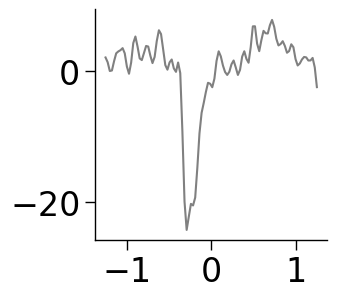

In [36]:
# plot each waveform
ix = 10

# setup plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)

# plot waveform instances
waveform_instances = waveform[0, :, max_site_ix].T
ax.plot(time_axis, waveform_instances, color=colors[0],
        lw=linewidth_instance,
        label="spike instances",
)

In [20]:
# # takes 1.5 min
# fig, ax = waveform.plot(
#     WaveformExtractor=We,
#     cell_id=142,
#     colors=[(0.5, 0.5, 0.5), (0, 0, 0)],  # orange
#     linewidth_instance=1.5,
#     linewidth_mean=2,
#     nspike=20,  # 20 spikes
# )

# plt.axis("off")
# ax.set_title("")

# fig

# if SAVE_FIG:

#     plt.savefig(
#         "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_positive_spike_shape_1.pdf",
#         **savefig_cfg
#     )
#     plt.savefig(
#         "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_positive_spike_shape_1.svg",
#         **savefig_cfg
#     )
#     fig

In [ ]:
# import spikeinterface.core.template_tools as ttools

# WaveformExtractor = We
# cell_id = 49
# nspike = 20

# # Turn interactive plotting off (lots of plots !)
# plt.ioff()

# # get channels where spike amplitude is maximal
# max_chids = ttools.get_template_extremum_channel(
#     WaveformExtractor, peak_sign="both"
# )

# # get cell waveforms
# waveform = WaveformExtractor.get_waveforms(cell_id)

# # derived peri-spike time period (ms)
# ms_before = (
#     -WaveformExtractor.nbefore
#     / WaveformExtractor.sampling_frequency
#     * 1000
# )
# ms_after = (
#     WaveformExtractor.nafter / WaveformExtractor.sampling_frequency * 1000
# )
# timepoint_ms = 1 / WaveformExtractor.sampling_frequency * 1000
# n_timepoints = int(
#     (abs(ms_before) / timepoint_ms) + (ms_after / timepoint_ms)
# )
# time_axis = np.linspace(ms_before, ms_after, num=n_timepoints)

# # set plot
# fig = plt.figure(figsize=(3, 3))
# ax = fig.add_subplot(1, 1, 1)

# # # plot waveform instances
# waveform_instances = waveform[:nspike, :, max_chids[cell_id]].T
# # ax.plot(
# #     time_axis,
# #     waveform_instances,
# #     color=colors[0],
# #     lw=linewidth_instance,
# #     label="spike instances",
# # )

# # # plot average waveform
# # tmp = WaveformExtractor.get_template(cell_id)
# # ax.plot(
# #     time_axis,
# #     tmp[:, max_chids[cell_id]],
# #     color=colors[1],
# #     label="average spike",
# #     lw=linewidth_mean
# # )

# # # setup legends
# # ax.set_xlabel(
# #     "time to spike timestamp (msecs)",
# #     fontsize=10,
# # )
# # ax.set_ylabel("extracellular potential (V)", fontsize=10)
# # ax.set_title(
# #     f"Cell id: {cell_id} on Channel {max_chids[cell_id]}", fontsize=10
# # )
# # handles, labels = ax.get_legend_handles_labels()
# # display = (0, waveform_instances.shape[1])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

AttributeError: 'dict' object has no attribute 'astype'

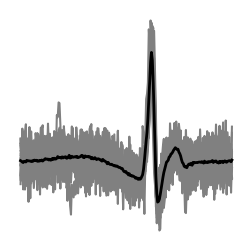

In [ ]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=We,
    cell_id=142,
    colors=[(0.5, 0.5, 0.5), (0, 0, 0)],  # orange
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

if SAVE_FIG:

    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_positive_spike_shape_1.pdf",
        **savefig_cfg
    )
    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_positive_spike_shape_1.svg",
        **savefig_cfg
    )
    fig

3 ms period

Text(0.5, 1.0, '')

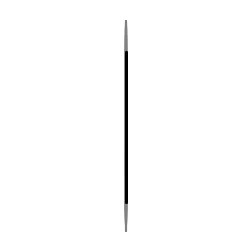

In [ ]:
# cell_id = 142

# ms_before = 1.5
# ms_after = 1.5
# nspike = 20

# # get channels where spike amplitude is maximal
# max_chids = spost.get_template_extremum_channel(WaveformExtractor, peak_sign="both")

# # get cell waveforms
# waveform = WaveformExtractor.get_waveforms(cell_id)

# # get time period
# timestamp = int(WaveformExtractor.nsamples / 2)
# timestep_ms = 1 / WaveformExtractor.sampling_frequency * 1000
# tp_before = int(ms_before / timestep_ms)
# tp_after = int(ms_after / timestep_ms)

# # plot waveform instances in sepecified period
# waveform_instances = waveform[
#     :nspike, timestamp - tp_before : timestamp + tp_after, max_chids[cell_id]
# ].T

# # set plot
# fig = plt.figure(figsize=(3, 3))
# ax = fig.add_subplot(1, 1, 1)

# plt.plot(waveform_instances, color=(0.5, 0.5, 0.5))
# plt.plot(np.mean(waveform_instances, axis=1), color=(0, 0, 0))

### Fast spiking Profile 2

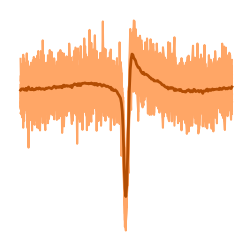

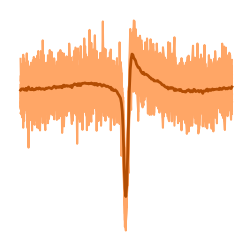

In [ ]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=150,
    colors=[(1, 0.65, 0.4), (0.7, 0.3, 0.01)],
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

if SAVE_FIG:
    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_fast_spiking_spike_shape_2.pdf",
        **savefig_cfg
    )
    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_fast_spiking_spike_shape_2.svg",
        **savefig_cfg
    )

    plt.show()

3 ms period

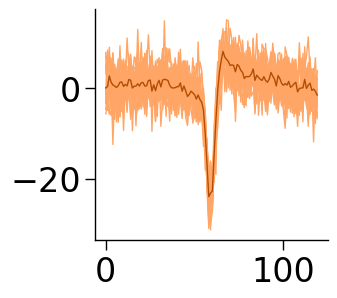

In [28]:
cell_id = 150

ms_before = 1.5
ms_after = 1.5
nspike = 20

# get channels where spike amplitude is maximal
max_chids = spost.get_template_extremum_channel(WaveformExtractor, peak_sign="both")

# get cell waveforms
waveform = WaveformExtractor.get_waveforms(cell_id)

# get time period
timestamp = int(WaveformExtractor.nsamples / 2)
timestep_ms = 1 / WaveformExtractor.sampling_frequency * 1000
tp_before = int(ms_before / timestep_ms)
tp_after = int(ms_after / timestep_ms)

# plot waveform instances in sepecified period
waveform_instances = waveform[
    :nspike, timestamp - tp_before : timestamp + tp_after, max_chids[cell_id]
].T

# set plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)

plt.plot(waveform_instances, color=(1, 0.65, 0.4))
plt.plot(np.mean(waveform_instances, axis=1), color=(0.7, 0.3, 0.01))

In [30]:
6 * 0.0576 / 0.5
6 * 0.0576 / 0.5

0.6912

### Triphasic Profile 3

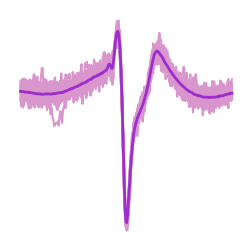

In [ ]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=536,
    colors=[(0.85, 0.59, 0.8), (0.62, 0.18, 0.8)],
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

if SAVE_FIG:

    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_triphasic_spike_shape_3.pdf",
        **savefig_cfg
    )
    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_triphasic_spike_shape_3.svg",
        **savefig_cfg
    )

    fig

### Compound spiking Profile 4

<Figure size 640x480 with 0 Axes>

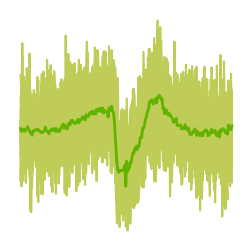

In [ ]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=196,
    colors=[(0.75, 0.8, 0.34), (0.38, 0.70, 0)],  # green
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

if SAVE_FIG:

    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_compound_spike_shape_4.pdf",
        **savefig_cfg
    )
    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_compound_spike_shape_4.svg",
        **savefig_cfg
    )
    plt.show()

### Regular spiking profile 5

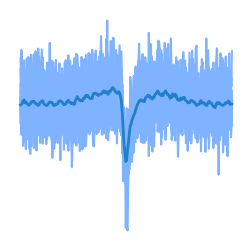

In [ ]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=200,
    colors=[(0.5, 0.7, 1), (0.13, 0.5, 0.8)],
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

if SAVE_FIG:

    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_regular_spike_shape_5.pdf",
        **savefig_cfg
    )
    plt.savefig(
        "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_regular_spike_shape_5.svg",
        **savefig_cfg
    )
    plt.show()